# Deep learning for computer vision


# CIFAR dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="https://github.com/yandexdataschool/Practical_DL/blob/fall23/week03_convnets/cifar10.jpg?raw=1" style="width:80%">

In [37]:
# when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2024-10-08 19:20:11--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2024-10-08 19:20:11 (57.2 MB/s) - ‘cifar.py’ saved [2396/2396]



In [38]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


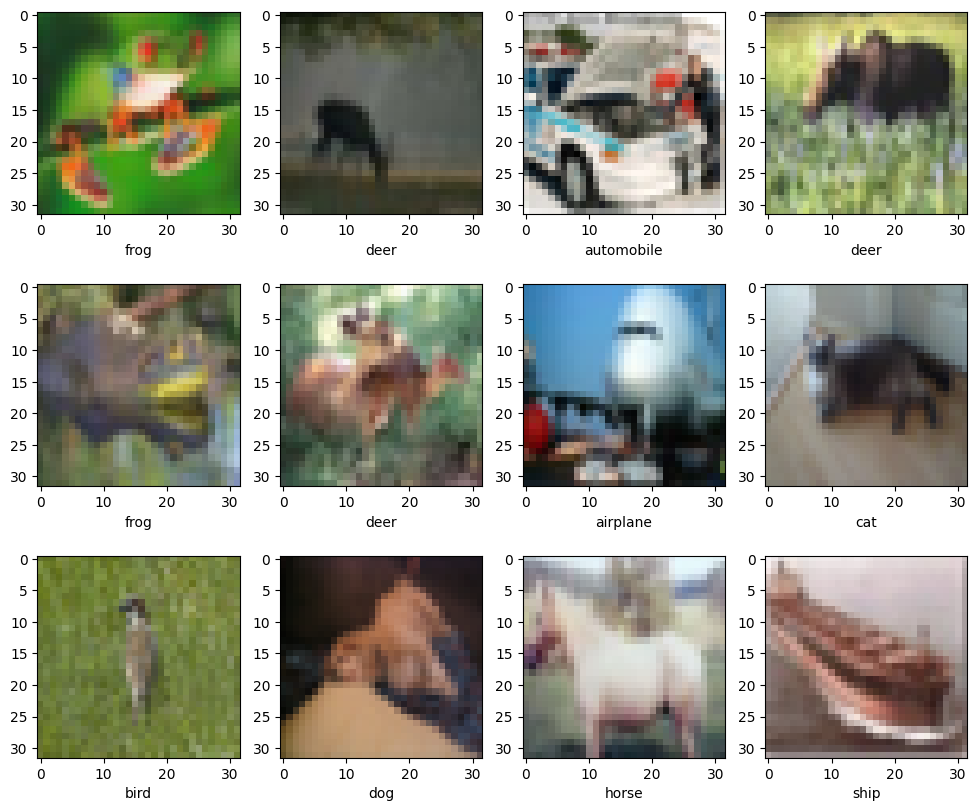

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another implemented with pytorch as `torch.nn.Sequential`.

In [40]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Starting with a dense network for our baseline:

In [41]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

We train model with negative log-likelihood aka crossentropy.

In [42]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [43]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.3016, grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [44]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [45]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [46]:
# Model training

import time
num_epochs = 25 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 25 took 1.286s
  training loss (in-iteration): 	2.046503
  validation accuracy: 			33.33 %
Epoch 2 of 25 took 1.288s
  training loss (in-iteration): 	1.866612
  validation accuracy: 			35.53 %
Epoch 3 of 25 took 1.272s
  training loss (in-iteration): 	1.799387
  validation accuracy: 			37.79 %
Epoch 4 of 25 took 1.269s
  training loss (in-iteration): 	1.747250
  validation accuracy: 			39.82 %
Epoch 5 of 25 took 1.292s
  training loss (in-iteration): 	1.705987
  validation accuracy: 			40.71 %
Epoch 6 of 25 took 1.281s
  training loss (in-iteration): 	1.670868
  validation accuracy: 			41.76 %
Epoch 7 of 25 took 1.358s
  training loss (in-iteration): 	1.639267
  validation accuracy: 			43.37 %
Epoch 8 of 25 took 1.855s
  training loss (in-iteration): 	1.612602
  validation accuracy: 			43.77 %
Epoch 9 of 25 took 1.753s
  training loss (in-iteration): 	1.590659
  validation accuracy: 			43.62 %
Epoch 10 of 25 took 1.292s
  training loss (in-iteration): 	1.570497
  validation 



```

```

```

### Final test

In [47]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		45.41 %
We need more magic! Follow instructons below


## A small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


In [48]:
import torch
import torch.nn as nn

# Define the model
model = nn.Sequential()

# First Convolutional Block
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(2))  # Max pooling 2x2

# Second Convolutional Block
model.add_module('conv2', nn.Conv2d(in_channels=10, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(2))  # Max pooling 2x2


# Flattening
model.add_module('flatten', nn.Flatten())

# Fully Connected Layers
model.add_module('dense1', nn.Linear(8192, 100))  # Adjust input size based on the previous layer
model.add_module('relu2', nn.ReLU())
model.add_module('dropout', nn.Dropout(0.1))  # 10% dropout
model.add_module('dense2_logits', nn.Linear(100, 10))  # Output layer

# print(model)

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=8192, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (dense2_logits): Linear(in_features=100, out_features=10, bias=True)
)

In [50]:
# Data transformations
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_test.shape,y_test.shape)
# printout must be (40000, 3, 32, 32) (40000,)

X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
X_batch_tensor = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
y_batch_tensor = torch.as_tensor(y_batch, dtype=torch.int64).to(device)

(10000, 3, 32, 32) (10000,)


In [51]:
# Compute loss function
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()


# Test loss function
compute_loss(X_train[:5], y_train[:5])

tensor(2.3271, device='cuda:0', grad_fn=<MeanBackward0>)

In [52]:
# Optimizer with Adam
opt = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss = []
val_accuracy = []

In [53]:
# Training Phase

import time
num_epochs = 25  # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    start_time = time.time()

    # Training mode
    model.train(True)
    # remove this tensor conversion because compute error doing it already
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # Move data to GPU
        X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
        y_batch = torch.as_tensor(y_batch, dtype=torch.long).to(device)

        # Compute loss and backpropagate
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()

        # Append training loss
        train_loss.append(loss.item())

    # Evaluation on validation data
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
            # Move data to GPU
            X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
            y_batch = torch.as_tensor(y_batch, dtype=torch.long).to(device)

            # Forward pass and prediction
            logits = model(X_batch)
            y_pred = logits.max(1)[1].cpu().numpy()
            val_accuracy.append(np.mean(y_batch.cpu().numpy() == y_pred))

    # Print the results for the current epoch
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size:])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size:]) * 100))


Epoch 1 of 25 took 2.454s
  training loss (in-iteration): 	1.424971
  validation accuracy: 			61.00 %
Epoch 2 of 25 took 2.326s
  training loss (in-iteration): 	1.060936
  validation accuracy: 			64.02 %
Epoch 3 of 25 took 2.449s
  training loss (in-iteration): 	0.922831
  validation accuracy: 			64.77 %
Epoch 4 of 25 took 2.497s
  training loss (in-iteration): 	0.822161
  validation accuracy: 			67.85 %
Epoch 5 of 25 took 2.312s
  training loss (in-iteration): 	0.739766
  validation accuracy: 			68.07 %
Epoch 6 of 25 took 2.310s
  training loss (in-iteration): 	0.661913
  validation accuracy: 			68.43 %
Epoch 7 of 25 took 2.316s
  training loss (in-iteration): 	0.596142
  validation accuracy: 			67.44 %
Epoch 8 of 25 took 2.363s
  training loss (in-iteration): 	0.531601
  validation accuracy: 			67.97 %
Epoch 9 of 25 took 2.570s
  training loss (in-iteration): 	0.477788
  validation accuracy: 			68.82 %
Epoch 10 of 25 took 2.466s
  training loss (in-iteration): 	0.427814
  validation 

In [54]:
# Test Phase

model.eval() # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		65.98 %
Achievement unlocked: 70lvl Warlock!


```

```

```

```

```

```

```

```

```

```


## Adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
* Re-train the network with the same optimizer to get at least 60% validation accuracy at peak.



In [55]:
# Added batch normalizations

model_v2 = nn.Sequential(
    model[0],
    nn.BatchNorm2d(10),
    model[1],
    model[2],
    model[3],
    nn.BatchNorm2d(128),
    model[4],
    model[5],
    model[6],
    model[7],
    nn.BatchNorm1d(100),
    model[8],
    model[9]
)

# Reload updated model to device
model_v2.to(device)
print(model_v2)

Sequential(
  (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(10, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=8192, out_features=100, bias=True)
  (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=10, bias=True)
)


In [56]:
# Reload data
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

# Reinit optimizer and eval list
opt = torch.optim.Adam(model_v2.parameters(), lr=0.001)

train_loss = []
val_accuracy = []

# Training Phase

import time
num_epochs = 25
batch_size = 50
for epoch in range(num_epochs):
    start_time = time.time()

    # Training mode
    model_v2.train(True)  # enable dropout

    # Iterate over mini-batches of training data
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # Move data to GPU
        X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
        y_batch = torch.as_tensor(y_batch, dtype=torch.long).to(device)

        # Compute loss and backpropagate
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()

        # Append training loss
        train_loss.append(loss.item())

    # Evaluation on validation data
    model_v2.eval()
    with torch.no_grad():
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
            # Move data to GPU
            X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
            y_batch = torch.as_tensor(y_batch, dtype=torch.long).to(device)

            # Forward pass and prediction
            logits = model_v2(X_batch)
            y_pred = logits.max(1)[1].cpu().numpy()  # Move predictions back to CPU
            val_accuracy.append(np.mean(y_batch.cpu().numpy() == y_pred))  # Move ground truth to CPU

    # Print the results for the current epoch
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size:])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size:]) * 100))


Epoch 1 of 25 took 2.637s
  training loss (in-iteration): 	0.156407
  validation accuracy: 			64.43 %
Epoch 2 of 25 took 2.733s
  training loss (in-iteration): 	0.136185
  validation accuracy: 			65.52 %
Epoch 4 of 25 took 2.483s
  training loss (in-iteration): 	0.138106
  validation accuracy: 			65.77 %
Epoch 5 of 25 took 2.497s
  training loss (in-iteration): 	0.134096
  validation accuracy: 			65.57 %
Epoch 6 of 25 took 2.610s
  training loss (in-iteration): 	0.124820
  validation accuracy: 			64.77 %
Epoch 7 of 25 took 2.727s
  training loss (in-iteration): 	0.119163
  validation accuracy: 			64.99 %
Epoch 8 of 25 took 2.524s
  training loss (in-iteration): 	0.124297
  validation accuracy: 			65.21 %
Epoch 9 of 25 took 2.523s
  training loss (in-iteration): 	0.124010
  validation accuracy: 			65.31 %
Epoch 10 of 25 took 2.504s
  training loss (in-iteration): 	0.118481
  validation accuracy: 			65.72 %
Epoch 11 of 25 took 2.625s
  training loss (in-iteration): 	0.097324
  validation

In [57]:
# Test Phase

model_v2.eval()
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model_v2(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		64.41 %
Achievement unlocked: 70lvl Warlock!



```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Data Augmentation

Using a torch tool for image preprocessing to do data preprocessing and augmentation.

Works as defining a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [58]:
from torchvision import transforms

means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [59]:
from torchvision.datasets import CIFAR10

train_loader = CIFAR10("./cifar_data/", train=True, download=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader,
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

# for idx, (x_batch, y_batch) in enumerate(train_batch_gen):
#     print('X:', type(x_batch), x_batch.shape)
#     print('y:', type(y_batch), y_batch.shape)

Files already downloaded and verified


In [60]:
# Test transform
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = CIFAR10("./cifar_data/", train = False,  transform=transform_test)
test_batch_gen = torch.utils.data.DataLoader(test_loader,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=1)

# for idx, (x_batch, y_batch) in enumerate(test_batch_gen):
#     print('X:', type(x_batch), x_batch.shape)
#     print('y:', type(y_batch), y_batch.shape)

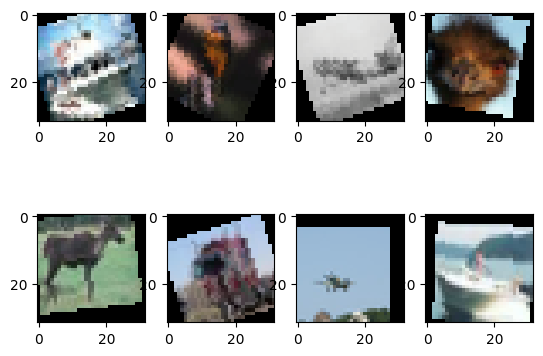

Epoch 1 of 25 took 64.198s
  training loss (in-iteration): 	7.598569
  validation accuracy: 			23.70 %
Epoch 2 of 25 took 62.825s
  training loss (in-iteration): 	4.769149
  validation accuracy: 			29.99 %
Epoch 3 of 25 took 63.448s
  training loss (in-iteration): 	3.725345
  validation accuracy: 			35.31 %
Epoch 4 of 25 took 62.510s
  training loss (in-iteration): 	3.158610
  validation accuracy: 			39.11 %
Epoch 5 of 25 took 63.002s
  training loss (in-iteration): 	2.799734
  validation accuracy: 			42.15 %
Epoch 6 of 25 took 62.046s
  training loss (in-iteration): 	2.548820
  validation accuracy: 			44.12 %
Epoch 7 of 25 took 63.332s
  training loss (in-iteration): 	2.364276
  validation accuracy: 			45.96 %
Epoch 8 of 25 took 62.134s
  training loss (in-iteration): 	2.222125
  validation accuracy: 			47.41 %
Epoch 9 of 25 took 62.673s
  training loss (in-iteration): 	2.108959
  validation accuracy: 			48.48 %
Epoch 10 of 25 took 76.198s
  training loss (in-iteration): 	2.015897
  v

In [61]:
# Reinit optimizer and eval list
opt = torch.optim.Adam(model_v2.parameters(), lr=0.001)

train_loss = []
val_accuracy = []

# Training Phase
import time
num_epochs = 25  # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    start_time = time.time()

    # Training mode
    model_v2.train(True)
    for batch_idx, (x_batch, y_batch) in enumerate(train_batch_gen):
# tako out tensor conversion
        X_batch = torch.as_tensor(x_batch, dtype=torch.float32).to(device)
        y_batch = torch.as_tensor(y_batch, dtype=torch.long).to(device)

        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss.append(loss.item())

        if epoch == 0 and batch_idx == 0:
            for i, img in enumerate(x_batch.numpy()[:8]):
                img = img.transpose([1, 2, 0]) * stds + means
                img = np.clip(img, 0, 1)
                plt.subplot(2, 4, i+1)
                plt.imshow(img)
            plt.show()

    # Evaluation on validation data
    model_v2.train(False)
    with torch.no_grad():
        for idx, (x_batch, y_batch) in enumerate(train_batch_gen):

            X_batch = torch.as_tensor(x_batch, dtype=torch.float32).to(device)
            y_batch = torch.as_tensor(y_batch, dtype=torch.long).to(device)

            logits = model_v2(X_batch)
            y_pred = logits.max(1)[1].cpu().numpy()
            val_accuracy.append(np.mean(y_batch.cpu().numpy() == y_pred))

      # Print the results for the current epoch
    epoch_time = time.time() - start_time  # Calculate epoch duration
    print(f"Epoch {epoch + 1} of {num_epochs} took {epoch_time:.3f}s")
    print(f"  training loss (in-iteration): \t{np.mean(train_loss):.6f}")  # Print mean training loss for the epoch
    print(f"  validation accuracy: \t\t\t{np.mean(val_accuracy) * 100:.2f} %")  # Print mean validation accuracy for the epoch


In [62]:
# Test Phase

model_v2.eval()
test_batch_acc = []

for batch_idx, (X_batch, y_batch) in enumerate(test_batch_gen):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
    y_batch = torch.as_tensor(y_batch).to(device)

    with torch.no_grad():
        logits = model_v2(X_batch)

    # Get predictions
    y_pred = logits.argmax(dim=1).cpu().numpy()
    y_batch = y_batch.cpu().numpy()

    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		70.23 %
Achievement unlocked: 80lvl Warlock!


# The Quest For A Better Network

building a monster network to solve CIFAR10 image classification.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as possible.

    
## Restrictions
* To NOT use pre-trained networks for this the task here.
  
```


### Model Packages Set Up

In [23]:
# IMPORT packages
# ! pip install timm torcheval tqdm

import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
# import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
PyTorch version 2.4.1+cu121
Torchvision version 0.19.1+cu121
Numpy version 1.26.4
Pandas version 2.2.2


In [24]:
# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

#### Data Pipeline Mgr

In [25]:
# define TRANSFORMATIONS

means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=30, translate=(0.2, 0.2)),
        transforms.RandomRotation(30),
        transforms.GaussianBlur(kernel_size=25),
    ], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [26]:
# Load CIFAR-10 dataset with the defined transformations
train_loader = CIFAR10(root="./cifar_data/", train=True, download=True, transform=transform)
val_loader = CIFAR10(root="./cifar_data/", train=False, download=True, transform=transform_val)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
# Batch size
batch_size = 100

# DataLoader for the training dataset
trainset = DataLoader(train_loader,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=2)

# DataLoader for validation/test dataset
valset = DataLoader(val_loader,
                    batch_size=batch_size,
                    shuffle=False,
                    num_workers=2)

#### CNN Model Definition

In [32]:
# Initialize customer cnn model

v8_model = nn.Sequential()

# 1st conv layer
v8_model.add_module("conv1", nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1))
v8_model.add_module("bn1", nn.BatchNorm2d(64))
v8_model.add_module('relu1', nn.ReLU())
v8_model.add_module("conv2", nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1))
v8_model.add_module("bn2", nn.BatchNorm2d(64))
v8_model.add_module('relu2', nn.ReLU())
v8_model.add_module('pool1', nn.MaxPool2d(2))  # Max pooling 2x2

v8_model.add_module("conv3", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
v8_model.add_module("bn3", nn.BatchNorm2d(128))
v8_model.add_module('relu3', nn.ReLU())
v8_model.add_module("conv4", nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1))
v8_model.add_module("bn4", nn.BatchNorm2d(128))
v8_model.add_module('relu4', nn.ReLU())
v8_model.add_module('pool2', nn.MaxPool2d(2))  # Max pooling 2x2

v8_model.add_module("conv5", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
v8_model.add_module("bn5", nn.BatchNorm2d(256))
v8_model.add_module('relu5', nn.ReLU())
v8_model.add_module("conv6", nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1))
v8_model.add_module("bn6", nn.BatchNorm2d(256))
v8_model.add_module('relu6', nn.ReLU())
v8_model.add_module('pool3', nn.MaxPool2d(2))  # Max pooling 2x2

v8_model.add_module("conv7", nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1))
v8_model.add_module("bn7", nn.BatchNorm2d(512))
v8_model.add_module('relu7', nn.ReLU())
v8_model.add_module("conv8", nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1))
v8_model.add_module("bn8", nn.BatchNorm2d(512))
v8_model.add_module('relu8', nn.ReLU())
v8_model.add_module('pool4', nn.MaxPool2d(2))  # Max pooling 2x2

v8_model.add_module("conv9", nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1))
v8_model.add_module("bn9", nn.BatchNorm2d(1024))
v8_model.add_module('relu9', nn.ReLU())
v8_model.add_module("conv10", nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1))
v8_model.add_module("bn10", nn.BatchNorm2d(1024))
v8_model.add_module('relu10', nn.ReLU())
v8_model.add_module('pool5', nn.MaxPool2d(2))  # Max pooling 2x2

# add flattening
v8_model.add_module("flatten", nn.Flatten())

# Dense layers
v8_model.add_module('dense1', nn.Linear(1024, 512))
v8_model.add_module("bn11", nn.BatchNorm1d(512))
v8_model.add_module('relu11', nn.ReLU())
v8_model.add_module('dropout1', nn.Dropout(0.1))  # 10% dropout

v8_model.add_module('dense2', nn.Linear(512, 256))
v8_model.add_module("bn12", nn.BatchNorm1d(256))
v8_model.add_module('relu12', nn.ReLU())
v8_model.add_module('dropout2', nn.Dropout(0.1))

v8_model.add_module('dense3_logits', nn.Linear(256, 10))
# v8_model.add_module('softmax', nn.Softmax(dim=1))  #Softmax for classification

# Load Model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
v8_model.to(device)

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [33]:
# Compute loss function

def compute_loss(X_batch, y_batch):
    # Convert X_batch and y_batch to PyTorch tensors
    X_batch = torch.as_tensor(X_batch.to(device, dtype=torch.float32))
    y_batch = torch.as_tensor(y_batch.to(device, dtype=torch.int64))

    # Perform the forward pass through the model
    logits = v8_model(X_batch)  # Output from the model

    # Compute the cross-entropy loss
    return F.cross_entropy(logits, y_batch).mean()  # Return mean of loss across batch

In [34]:
# Test loss function

X_batch, y_batch = next(iter(trainset))
loss = compute_loss(X_batch, y_batch)
print(f"Loss: {loss.item()}")

Loss: 2.4013543128967285


#### Model Training and Evaluation

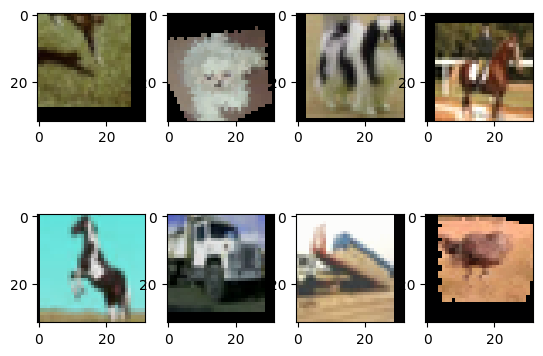

Epoch 1 of 25 took 87.848s
  training loss (in-iteration): 	1.719394
  validation accuracy: 			49.94 %
Epoch 2 of 25 took 86.782s
  training loss (in-iteration): 	1.427708
  validation accuracy: 			61.63 %
Epoch 3 of 25 took 85.773s
  training loss (in-iteration): 	1.281155
  validation accuracy: 			66.87 %
Epoch 4 of 25 took 85.647s
  training loss (in-iteration): 	1.173371
  validation accuracy: 			66.58 %
Epoch 5 of 25 took 84.771s
  training loss (in-iteration): 	1.099122
  validation accuracy: 			70.70 %
Epoch 6 of 25 took 85.278s
  training loss (in-iteration): 	1.040183
  validation accuracy: 			73.30 %
Epoch 7 of 25 took 84.664s
  training loss (in-iteration): 	0.986966
  validation accuracy: 			77.28 %
Epoch 8 of 25 took 85.644s
  training loss (in-iteration): 	0.955207
  validation accuracy: 			78.04 %
Epoch 9 of 25 took 85.649s
  training loss (in-iteration): 	0.919171
  validation accuracy: 			80.35 %
Epoch 10 of 25 took 85.385s
  training loss (in-iteration): 	0.883796
  v

In [35]:
# Training Phase
import time
num_epochs = 25
batch_size  # number of samples processed in one iteration

# Optimizer
opt = torch.optim.AdamW(v8_model.parameters(), lr=0.0001, weight_decay=0.01)

for epoch in range(num_epochs):
    start_time = time.time()

    # Training mode
    v8_model.train(True)
    train_loss = []
    for batch_idx, (x_batch, y_batch) in enumerate(trainset):
        X_train, y_train = x_batch.to(device), y_batch.to(device)
        # y_train = torch.as_tensor(y_batch, dtype=torch.long).to(device)

        loss = compute_loss(X_train, y_train)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss.append(loss.item())

        if epoch == 0 and batch_idx == 0: # display from only first epoch
            for i, img in enumerate(X_train.cpu().numpy()[:8]):
                img = img.transpose([1, 2, 0]) * stds + means
                img = np.clip(img, 0, 1)
                plt.subplot(2, 4, i+1)
                plt.imshow(img)
            plt.show()

    # Evaluation on validation data
    v8_model.train(False)
    val_accuracy = []
    with torch.no_grad():
        for batch_idx, (x_batch, y_batch) in enumerate(valset):
            if x_batch.size(0) < batch_size:  # Check if batch size is less than expected
                continue  # Skip this iteration
            X_val = torch.as_tensor(x_batch, dtype=torch.float32).to(device)
            y_val = torch.as_tensor(y_batch, dtype=torch.long).to(device)

            logits = v8_model(X_val)
            y_pred = logits.max(1)[1].cpu().numpy()  # Move predictions back to CPU
            val_accuracy.append(np.mean(y_val.cpu().numpy() == y_pred))  # Move ground truth to CPU

        # Print the results for the current epoch
    epoch_time = time.time() - start_time  # Calculate epoch duration
    print(f"Epoch {epoch + 1} of {num_epochs} took {epoch_time:.3f}s")
    print(f"  training loss (in-iteration): \t{np.mean(train_loss):.6f}")  # Print mean training loss for the epoch
    print(f"  validation accuracy: \t\t\t{np.mean(val_accuracy) * 100:.2f} %")  # Print mean validation accuracy for the epoch


#### Model Testing

In [36]:
# Test Phase

v8_model.eval()
test_batch_acc = []

for batch_idx, (X_batch, y_batch) in enumerate(valset):
    X_test = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
    y_test = torch.as_tensor(y_batch).to(device)

    with torch.no_grad():
        logits = v8_model(X_test)

    # Get predictions
    y_pred = logits.argmax(dim=1).cpu().numpy()
    y_test = y_test.cpu().numpy()

    test_batch_acc.append(np.mean(y_test == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		85.73 %
Achievement unlocked: 110lvl Warlock!


```
```
```
```

## MINI REPORT

### Network Performance Optimization: Experimental Findings

## Iteration Path

The iteration path followed a systematic approach, starting with baseline experiments using different batch sizes, then progressively incorporating advanced optimization techniques and structural modifications. Initially, models were trained with batch sizes of 128 and 50 to evaluate their impact on accuracy and convergence. After identifying the influence of batch size, Adam and AdamW optimizers were introduced, with weight decay added to enhance regularization. Architectural adjustments, including the removal of convolutional layers, were also tested. Finally, a well-tuned configuration combining optimal batch size, learning rate, and weight decay yielded the best performance, marking the culmination of this iterative process.

## Batch Size Experiments

### Experiment 1: Batch Size of 128
- **Initial Accuracy**: 56%
- **Final Test Accuracy**: 84%
- **Train Loss**: 0.6

Using a batch size of 128 resulted in a marked improvement in accuracy over multiple epochs. The model began with a reasonable starting accuracy of 56% and converged to a final accuracy of 84%, with a loss value of 0.6 suggesting that the model fit the data well.

### Experiment 2: Batch Size of 50
- **Initial Accuracy**: 39%
- **Final Test Accuracy**: 74%
- **Train Loss**: 1.2

A smaller batch size of 50 led to slower convergence, starting with a lower initial accuracy of 39%. After five epochs, the model achieved a final accuracy of 74%.

### Experiment 3: Adam Optimizer with Weight Decay (Batch Size = 100)
- **Initial Accuracy**: 38%
- **Final Test Accuracy (11th Epoch)**: 81%
- **Train Loss**: 1.1

The use of the Adam optimizer with a weight decay of 0.01 and batch size of 100 started with low accuracy (38%). However, by the 11th epoch, the test accuracy improved to 81%, demonstrating that the Adam optimizer with weight decay can boost model learning over time.

### Experiment 4: Structural Changes (Batch Size = 100)
- **Initial Accuracy**: 47%
- **Final Test Accuracy (15th Epoch)**: 71%

After reducing the model's depth by removing five convolutional layers, the model began with an initial accuracy of 47%. By the 15th epoch, the accuracy settled at 71%, indicating that structural modifications can significantly affect model performance.

## Optimized Configuration Experiment

### Final Configuration
- **Batch Size**: 100
- **Optimizer**: AdamW with a learning rate of 0.0001 and weight decay of 0.01
- **Epochs**: 25
- **Initial Accuracy (1st Epoch)**: 49%
- **Final Accuracy (25th Epoch)**: 85%
- **Final Loss**: 0.64
- **Final Evaluation Score**: 85.73%

The optimized configuration resulted in a substantial performance increase over the 25 epochs. With fine-tuning of the learning rate and regularization using weight decay, the model attained a test accuracy of 85.73% with a lower train loss, showcasing the importance of proper hyperparameter optimization.

## Conclusion
The experiments highlighted several key takeaways regarding the optimization of neural network models:

- **Larger Batch Sizes**: A batch size of 128 achieved the highest final accuracy (84%), suggesting that larger batches stabilize gradient updates and improve convergence.
- **Smaller Batch Sizes**: A smaller batch size of 50 produced lower accuracy and slower convergence, indicating that it may not be suitable for this dataset.
- **Optimization Techniques**: The AdamW optimizer with weight decay significantly improved learning dynamics, contributing to a stronger performance over time.
- **Structural Modifications**: Architectural changes, such as removing layers, can adversely impact model accuracy. Careful consideration is required when modifying model structures.

## Future Work
Future optimizations will include fine-tuning hyperparameters further, exploring alternative architectures, and using pretrained models to push model performance to even higher levels.
